In [1]:
from helpers import *
import numpy as np
import pandas as pd
from implementations import *

In [2]:
## Use pickle instead of csv, much faster, please comment out below 
data_path = '../data/dataset/dataset_to_release'
x_train_preclean, x_test_preclean, y_train, train_ids, test_ids = load_csv_data(data_path)

# Data cleaning

### Getting an idea of the data 
Find really bad columns and drop them

In [3]:
print("X train", x_train_preclean.shape)
print("X test", x_test_preclean.shape)

X train (328135, 321)
X test (109379, 321)


Text(0, 0.5, '# of columns')

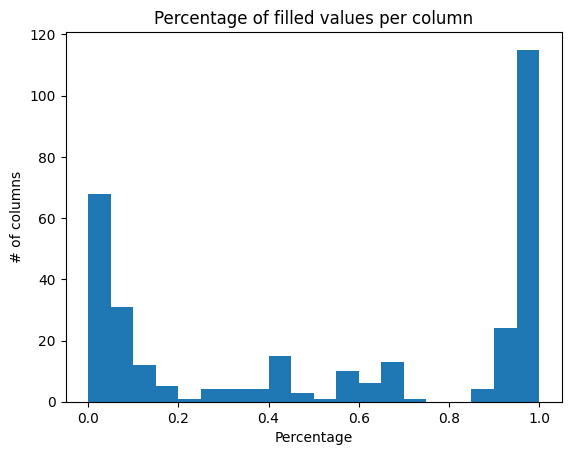

In [4]:
## Find how many values are completely empty in column
def percentageFilled(data):
    return 1 - np.isnan(data).sum() / len(data)


percentage_filled = np.apply_along_axis(percentageFilled, 0, x_train_preclean)

import matplotlib.pyplot as plt

plt.hist(percentage_filled, bins=20)
plt.title("Percentage of filled values per column")
plt.xlabel("Percentage")
plt.ylabel("# of columns")

In [5]:
## Process data 
## 1. drop the columns with more than 80% missing values
def threshold_col_filter(data, threshold):
    """ 
    filter out data where the column has less than threshold percentage of data
    returns: 
        indicies of columns to keep
    """
    percentage_filled = np.apply_along_axis(percentageFilled, 0, data)
    # keep_indicies = np.argwhere(percentage_filled > threshold).flatten()
    return percentage_filled > threshold


def non_constant_filter(data):
    return np.logical_not(np.logical_or(np.isnan(np.nanstd(data, 0)), np.nanstd(data, 0) == 0))

# TODO uncorrelation?

# TODO correlation w

keep_indicies = np.argwhere(np.logical_and(
    threshold_col_filter(x_train_preclean, 0.2), 
    non_constant_filter(x_train_preclean)
    )
).flatten()

print("keep_indicies", keep_indicies)

keep_indicies [  0   1   2   3   4   5   6   7   8  10  13  15  16  17  20  21  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  42  43
  44  45  46  47  48  50  51  52  53  54  56  57  58  59  60  61  62  63
  65  66  67  68  69  70  71  72  73  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 118 136 198 199 216 217 218 219 220 221 222 223 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320]


In [6]:
def filter_columns_by_indicies(data, keep_indicies):
    """
    used to process test data 
    only keep the columns that are in the indicies 
    """
    return data[:, keep_indicies]


x_train = filter_columns_by_indicies(x_train_preclean, keep_indicies)
print("X train", x_train.shape)

x_test = filter_columns_by_indicies(x_test_preclean, keep_indicies)
print("X test", x_test.shape)

X train (328135, 201)


### Data cleaning 

1. remove columns where 80% of the values are missing
2. replace the missing values of X with the mean of the column
3. standardize the data
4. add column of 1 at the beginning  

# **Make sure you do the same for x_test**

In [11]:
def is_categorical_feature(xn, threshold=0.05):
    return len(set(xn)) / len(xn) < threshold

def standardize(x):
    """Standardize the original data set."""
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0))

def one_hot_encode(xn):
    pass
     # TODO

# ind = np.apply_along_axis(is_categorical_feature, 0, x_train)

In [14]:
## 2. Replace the missing values with the mean of the column, add columns 
def standardize(x):
    """Standardize the original data set."""
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0))


def process_data(x):
    # col_means = np.nanmean(x, axis=0)
    # inds = np.where(np.isnan(x))
    # x[inds] = np.take(col_means, inds[1])  # replace columns with values NaN with the mean of that column
    # x = (x - np.mean(x)) / np.std(x)  # standarize the data 
    ## ?? I feel like standardizing by column shouldn't be done like above 
    x = standardize(x)
    x = np.c_[np.ones(len(x)), x]  # add the column of ones
    return x


x_train_std = process_data(x_train)
x_test_std = process_data(x_test)

# x_train_2 = process_data(x_train)
# x_test_2 = process_data(x_test_2)

# Logistic regression *without* regularization

In [15]:
initial_w = np.zeros(x_train_std.shape[1], dtype=np.float128)
max_iters = 100
gamma = 0.5

In [16]:
## Here the logistic regression is from implementations.py
## takes around 20 mins to run for 100 iters
w, loss = logistic_regression(y_train, x_train_std, initial_w, max_iters, gamma)

In [17]:
print("loss is ", loss)
print("w is ", w)

loss is  0.22981794954539787257
w is  [-2.83166341e+00  6.08272542e-03  7.93805852e-03 -1.53434155e-03
 -1.43305607e-03 -4.18027990e-03 -1.07245566e-02  5.22945720e-03
 -1.95187198e-03 -1.95187198e-03  3.10360281e-03 -6.98470933e-04
  1.23301082e-02  2.49478778e-02 -9.31566992e-03 -2.15348096e-02
 -6.84407464e-03 -4.71552603e-03 -2.26622704e-03  7.21163514e-03
  3.40544142e-01 -7.34708059e-02 -7.76772067e-03 -1.71119289e-02
 -1.47183934e-02  2.13619271e-02 -3.09180059e-02 -6.81944703e-03
 -1.73139101e-01 -8.37669543e-02 -5.91212526e-02 -6.66143051e-02
 -1.94266087e-01 -1.32372597e-01 -2.16688614e-02 -2.57680037e-02
 -3.13948605e-03 -6.30017865e-02 -2.78406115e-03 -1.83947277e-02
 -4.90576859e-02 -1.00070568e-01 -2.49316808e-01 -3.52128042e-02
 -1.59323519e-02  2.75987200e-02 -4.15364454e-04  2.08377479e-03
 -6.57333640e-02  1.19720240e-01  9.08085462e-03  1.40210008e-02
  4.21967726e-02 -3.04012584e-02  1.14801591e-02 -3.92857253e-02
 -5.21385821e-02 -1.78810459e-02 -3.06204065e-03 -4.

### Trying to predict x_test

In [18]:
def prediction_labels(weights, data):  ## isn't this for linear regression only ? Don't we need the sigmoid?
    """Generates class predictions given weights, and a test data matrix."""
    y_pred = sigmoid(np.dot(data, weights))
    # display(y_pred)
    y_pred[np.where(y_pred >= 0.5)] = 1
    y_pred[np.where(y_pred < 0.5)] = 0
    return y_pred


y_pred = prediction_labels(w, x_train_std)
temp = y_pred[y_pred != -1]
print("temp", temp.shape)

temp (328135,)


In [20]:
accuracy = (y_pred == y_train).sum() / len(y_train)
print("accuracy", accuracy)

accuracy 0.9135447300653694


In [ ]:
print("x_train_std", x_train_std.shape, "w shape", w.shape)

### Logistic regression with regularization